In [2]:
from scipy.signal import filtfilt
from scipy.signal import butter,lfilter
from scipy.signal import freqs,freqz
import numpy as np
from scipy.fft import fft,ifft,fftfreq
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.signal import hilbert
from scipy import signal
%matplotlib inline


import ipywidgets as widgets
from obspy.signal.trigger import recursive_sta_lta,carl_sta_trig,plot_trigger#,trigger_onset
from obspy.core.trace import Trace
from collections import deque 
from obspy.signal.trigger import ar_pick
from obspy.core.trace import Trace

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):#band pass filter using butter worth method
    '''returns the coeffecients for an nth order bandpass filter
    lowcut,highcut:- cutoff frequency
    fs:- sampling frequency
    order:-order if the filter
    output 
    a,b:- poles and zeros for the transfer function
    '''
    nyq = 0.5 * fs#nyquist frequency
    low = lowcut / nyq 
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')#parameters for filters/filter coefficients/coeff of digital transfer fn
    return b, a# coefficients of numerator and denomenator polynomial

In [4]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):#band pass filter using butter worth method
    '''returns the filtered data for a given data
    data:-original data
    lowcut,highcut:- cutoff frequency
    fs:- sampling frequency
    order:-order if the filter
    
    output
    y:filtered data 
    '''
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)# coefficients of numerator and denomenator polynomial
    y = lfilter(b, a, data)#fir filter
    return y#filtered data

In [5]:
rec_x=np.array(pd.read_csv('accln_121_83.csv')['X'])
rec_y=np.array(pd.read_csv('accln_121_83.csv')['Y'])
rec_z=np.array(pd.read_csv('accln_121_83.csv')['Z'])

pos_x=np.array(pd.read_csv('recx_pos_circ100.csv'))
pos_y=np.array(pd.read_csv('recy_pos_circ100.csv'))
tracex=Trace(rec_x)
tracey=Trace(rec_y)
tracez=Trace(rec_z)
#toa=ar_pick(tracex,tracey,tracez,952,1,50, 0.01, 0.001, 0.01,0.001, 2, 8, 0.1, 0.2)

[ 4.8828125]


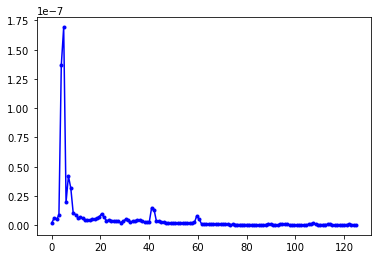

In [6]:
#print(toa)

freq,psd=signal.welch(rec_y,250)
plt.plot(freq,psd,'b.-')
print(freq[np.where(psd==psd.max())])

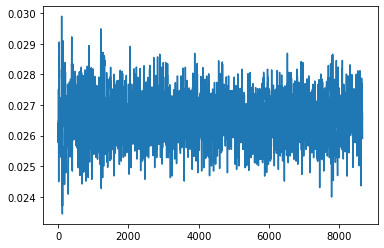

In [7]:
plt.plot(np.sqrt(rec_x**2+rec_y**2))

In [8]:
toa=[]
tracex=Trace(rec_x)
tracey=Trace(rec_y)
tracez=Trace(rec_z)
toa.append(ar_pick(tracex,tracey,tracez,40.5,1,20, 4, 0.1, 1.0, 1.0, 2, 8, 0.1, 0.2))

In [9]:
toa1=np.array(toa)
toa2=np.zeros(len(toa1))
for i in range(len(toa1)):
    toa2[i]=toa1[i][0]

In [10]:
toa

[(29.925926208496094, 0.0)]

In [11]:
def data_pack(X_data):
    '''data pack is used to create an envelope around the original readings of the accelerometer 
    X:- original data'''
    y = butter_bandpass_filter(X_data,30,50,500,order=5)# band pass filter between 5 and 7 hrtz
    y=abs(y)# to convert negative data from accelerometer to positive value 
    y_max=np.max(y)# max value recorded by accelerometer
    y_envelop=np.zeros_like(y)
    y_envelop_2=np.zeros_like(y)
    y_envelop[:]=(y[:]/y_max)-(y[:]/y_max)**2# a variable to almost map the original wave but with less ossciliations
    for i in range(1,len(y)):
        y_envelop_2[0]=y_envelop[0]
        y_envelop_2[i]=np.max(y_envelop[i-1:i+1])#to reduce the osscilations even further and make the data more uniform 
    y_hilbert=np.imag(hilbert(y_envelop_2))
    return y,y_hilbert, y_envelop_2

In [12]:
def trigger_event(thr_on,thr_off,k_or,time,sta_time=1,lta_time=60,df=1):
    '''
    returns the processed data in which only the data with event is diplayed
    thr_on,off:= threshold for wave onset and offset
    k_or,k,K_envelop_2,K_hilbert:- data and its processed form 
    lta,sta_time:- length of short time,long time window
    output:
    even:- an array that returns the actual even or set of events
    len(on_off):-no of events present in the data
    on,off:- points at which event starts and ends
    '''
    k,k_hilbert,k_envelop_2=data_pack(k_or)
    ratio_sta_lta=np.zeros(len(k))
    sta=0.#short term average 
    csta=1./sta_time# variable to reduce redudancy in writting the formula 
    clta=1./lta_time# variable to reduce redudancy in writting the formula 
    icsta=1-csta# variable to reduce redudancy in writting the formula 
    iclta=1-clta# variable to reduce redudancy in writting the formula 
    lta=1e-99# long term average 
    for i in range(len(k_envelop_2)):
        k_new=np.sqrt((k_envelop_2[i]**2)+(k_hilbert[i]**2))#value manipulation using hilber method
        sta=k_new*csta+icsta*sta
        lta=k_new*clta+iclta*lta
        if(i<lta_time):
            ratio_sta_lta[i]=0
        else:
            ratio_sta_lta[i]=sta/lta
    cft=ratio_sta_lta
    fig=plt.figure()
    plt.plot(time,cft-cft.mean())
    plt.xlabel('time')
    plt.ylabel('cft')
    print(cft.mean())
    trace=Trace(np.array(k_or))
    npts = trace.stats.npts
    t = np.arange(npts, dtype=np.float32) / df
    cft1=np.array(cft)
    on_off = np.array(trigger_onset(cft1, thr_on, thr_off))
    even=np.zeros(len(k_or))
    on=on_off[:,0]
    off=on_off[:,1]
    for i in range (0,len(on_off)):
        even[on[i]-1:off[i]]=k_or[on[i]-1:off[i]]
    return even,len(on),on,off

In [13]:
def trigger_onset(charfct, thres1, thres2, max_len=9e99, max_len_delete=False):#to determine when the event is triggred and di triggered 
    '''function returns the indices of the the points where a trigger onset is detected  and the offset of wave is considered 
    charfct:- ratio(sta,lta)
    threst1,2 threshold for wave onset and offset
    output:
    pick:- the indices at wich an event is hapening
    '''
    ind1 = np.where(charfct > thres1)[0]# for points when magnitude is above thresh 1 
    if len(ind1) == 0:
        return []
    ind2 = np.where(charfct > thres2)[0]# for points when magnitude is above thresh 2
    trigger_on = deque([ind1[0]])# for points when magnitude is above thresh 1
    trigger_of = deque([-1])
    # determine the indices where charfct falls below off-threshold
    ind2_ = np.empty_like(ind2, dtype=bool)
    ind2_[:-1] = np.diff(ind2) > 1# to give true for points where trigger goes below thresh 2 after the magnitude increases above thresh 1 
    # last occurence is missed by the diff, add it manually
    ind2_[-1] = True
    trigger_of.extend(ind2[ind2_].tolist())# to create an array which stores point where the the event ends 
    trigger_on.extend(ind1[np.where(np.diff(ind1) > 1)[0] + 1].tolist()) # to create an array which stores the point where the event starts 
    # include last pick if trigger is on or drop it
    if max_len_delete:# in case max_len_delete is true
        # drop it
        trigger_of.extend([1e99])
        trigger_on.extend([on[-1]])
    else:
        # include it
        trigger_of.extend([ind2[-1]])
    #
    pick = []
    while trigger_on[-1] > trigger_of[0]: # some boundry conditions to avoid some conflicts 
        while  trigger_on[0] <=  trigger_of[0]:
               trigger_on.popleft()# for because in case the value of sta/lta is greater than thresh 1 from the get go and can provide false triggers
        while  trigger_of[0] <  trigger_on[0]:
             trigger_of.popleft() # to remove the cases where the value is greater than thr 2 but not than thr 1 to avoid false triggers
        if  trigger_of[0] -  trigger_on[0] > max_len:
            if max_len_delete:
                trigger_on.popleft()
                continue
            trigger_of.appendleft( trigger_on[0] + max_len)
        pick.append([ trigger_on[0],  trigger_of[0]])
    return np.array(pick, dtype=np.int64)


In [14]:
def time_of_arrival(k_or,time,thr_on=1.3,thr_off=0.1,sta_time=10,lta_time=30,df=40):
    '''
    k_or=original data file
    time=time file
    thr_on=thereshhold value for starting of event
    thr_off=thereshhold value for ending of event
    sta_time=length of short term window
    lta_length=length of long term window
    df=sampling rate
    
    
    eg:
    recx_data=np.array(pd.read_csv('recx_data.csv'))
    time=np.linspace(0,1000,810)
    time_arrival=time_of_arrival(recx_data,time,df=810)
    '''
    event0,len_event0,index_on0,index_off0=trigger_event(thr_on,thr_off,k_or[0],sta_time,lta_time,df)
    time_arrival=np.zeros((len(k_or),len_event0))
    for k in range(len_event0):
        time_arrival[0][k]=time[index_on0[k]]
    for i in range(1,len(k_or)):
        event,len_event,index_on,index_off=trigger_event(thr_on,thr_off,k_or[i],sta_time,lta_time,df)
        for j in range(len_event):
            time_arrival[i][j]=time[index_on[j]]
    return time_arrival

In [15]:


time=np.array(pd.read_csv('accelerometer_data.csv')['Time'])

In [16]:
df=500

In [17]:
df

500

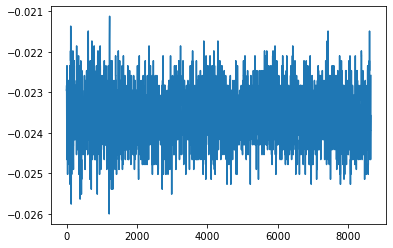

In [18]:
plt.plot(rec_x)

In [19]:
rec_x.reshape(len(rec_x))

array([-0.022949, -0.022949, -0.022827, ..., -0.023193, -0.022583,
       -0.022583])

In [20]:
def energy(event_arg,len_arg,on_arg,off_arg,time_event=0,df=1/532):
    '''
    event_arg:- the data of an event
    len_arg:- no of events in the given data
    on_arg,off_arg:-  points at which event starts and ends
    output: 
    energy_formula_1 the energy_formula of the diffrent events 
    '''
    energy_formula_1=np.zeros(len_arg)
    energy_formula_2=np.zeros(len_arg)
    energy_formula_3=np.zeros(len_arg)
    for j in range(len_arg):
        e3=np.array(event_arg[on_arg[j]:off_arg[j]-1])
        recfreq=np.fft.fftfreq(np.shape(e3)[0],df)
        ffta=np.zeros(shape=(np.size(recfreq)))
        ffta[:]=abs((np.fft.fft(e3)**2))
        energy_formula_1[j]=np.dot(np.power(recfreq,2),ffta[:])
        energy_formula_2[j]=np.mean(e3**2)
        energy_formula_3[j]=np.mean((recfreq[1]-recfreq[0])*ffta)*len(recfreq)
    return energy_formula_1

ValueError: x and y must have same first dimension, but have shapes (13489,) and (8657,)

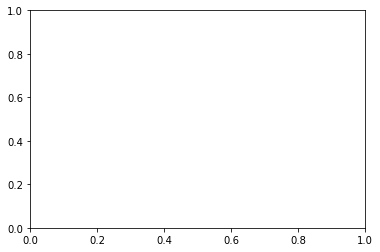

In [21]:
event,len_event,index_on,index_off=trigger_event(1,-0.5,np.sqrt(rec_x**2+rec_y**2+rec_z**2),time,10,90,500)
time_arrival=np.zeros((len_event))
for j in range(len_event):
    time_arrival[j]=time[index_on[j]]
energy1=energy(event,len_event,index_on,index_off)

In [ ]:
index_on

In [ ]:
print(energy1)

In [22]:
time_arrival

NameError: name 'time_arrival' is not defined

In [23]:
on_off=np.zeros((len(index_on),2))
for i in range(len(index_on)):
    on_off[i][0]=index_on[i]
    on_off[i][1]=index_off[i]

NameError: name 'index_on' is not defined

In [24]:
on_off[:, 0] /df

NameError: name 'on_off' is not defined

ValueError: x and y must have same first dimension, but have shapes (13489,) and (8657,)

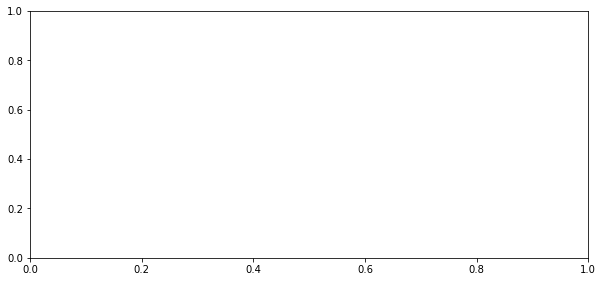

In [25]:






fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.plot(time,np.sqrt(rec_x**2+rec_y**2+rec_z**2), 'k')
ax1.set_xlabel('Time in seconds')
ax1.set_ylabel('Wave acceleration data')
i, j = ax1.get_ylim()
ax1.vlines(on_off[:, 0] /df, i, j, color='r', lw=2,label="Trigger On")
ax1.vlines(on_off[:, 1] /df, i, j, color='b', lw=2,label="Trigger Off")
ax1.legend()
   # ax2 = fig.add_subplot(212, sharex=ax1)
   # ax2.plot(time, cft, 'k')

In [47]:
recx=pd.read_csv
energyt=np.zeros(14)
peak_freq=np.zeros((15,3))

[ 31.171875]
1.0015704549
[ 22.859375]
0.993144145095
[ 2.078125]
0.960596998805
[ 31.171875]
1.00542535099
[ 18.703125]
0.991656027045
[ 22.859375]
0.960206412832
[ 31.171875]
1.00680533556
[ 18.703125]
0.994895552875
[ 18.703125]
0.959720303467
[ 24.9375]
1.01227599996
[ 12.46875]
0.995117271147
[ 22.859375]


/tmp/ipykernel_93/1756794586.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


0.960822452992
[ 29.09375]
1.00153780204
[ 16.625]
0.996909092536
[ 14.546875]
1.01444450325
[ 2.078125]
0.950239049911
[ 29.09375]
1.00265033258
[ 18.703125]
1.0036985721
[ 2.078125]
0.941177477196
[ 16.625]
0.956152153258
[ 16.625]
0.957459170431
[ 43.640625]
0.942376191224
[ 24.9375]
0.996473352671
[ 14.546875]
1.00173163032
[ 43.640625]
0.942376191224
[ 24.9375]
0.996473352671
[ 14.546875]
1.00173163032
[ 12.46875]
0.98116615422
[ 18.703125]
0.970796146924
[ 14.546875]
0.995445983688
[ 31.171875]
1.01550037626
[ 31.171875]
0.960117863296
[ 14.546875]
0.991896494314
[ 33.25]
0.95619923639
[ 27.015625]
0.942513492442
[ 12.46875]
0.945302441217
[ 24.9375]
1.01338257779
[ 29.09375]
0.942189549355
[ 12.46875]
0.98783376846


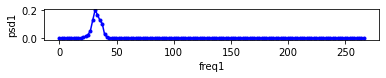

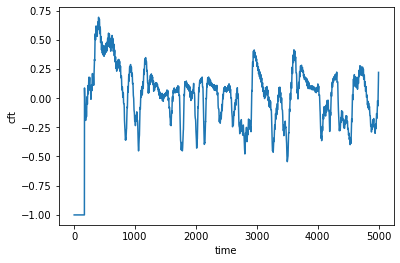

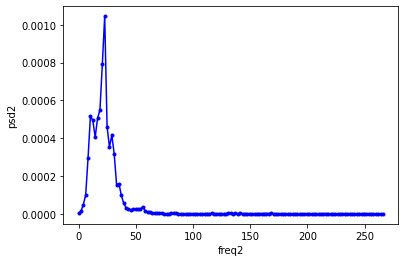

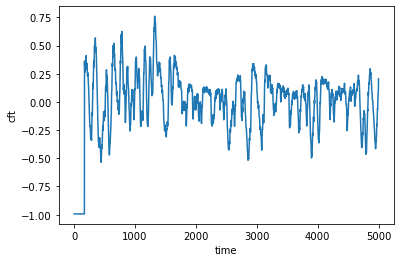

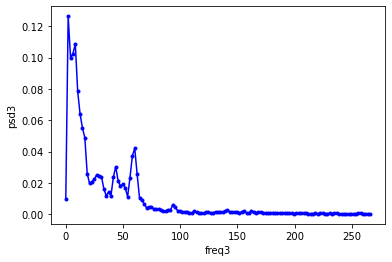

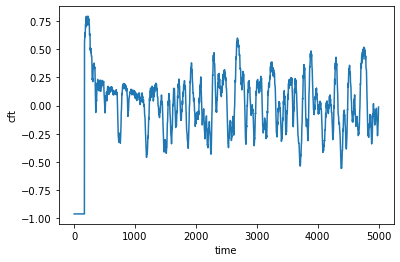

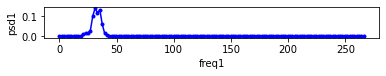

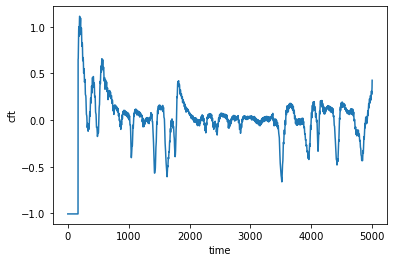

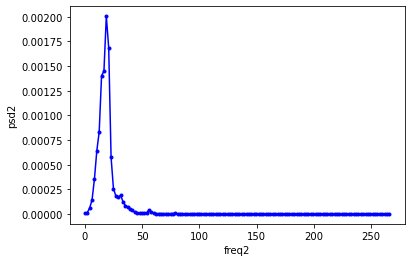

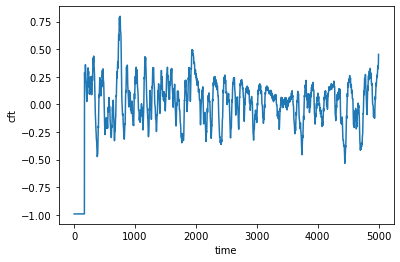

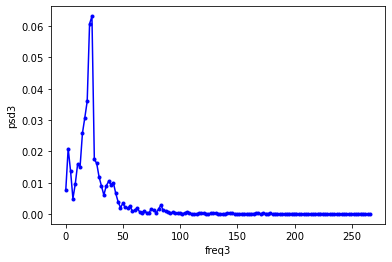

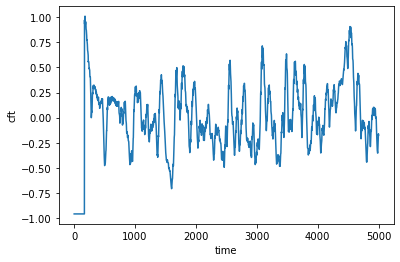

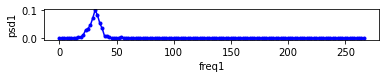

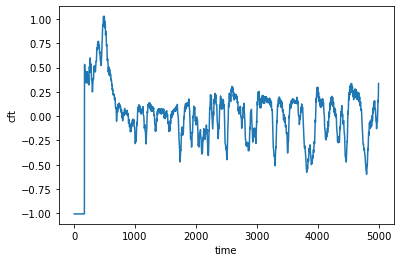

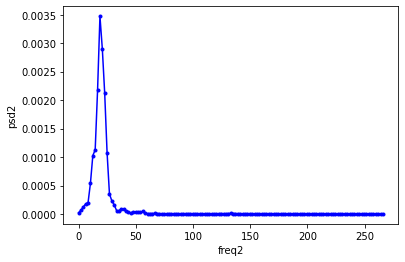

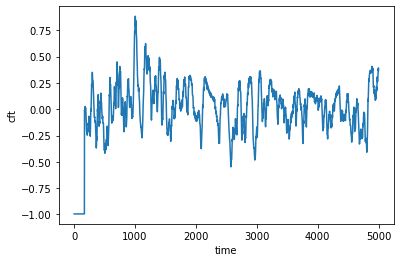

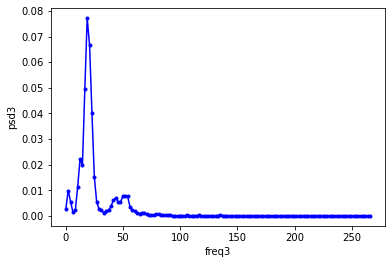

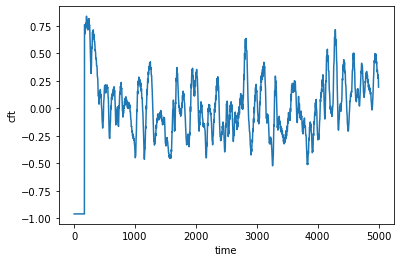

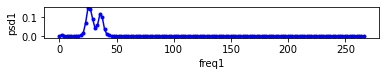

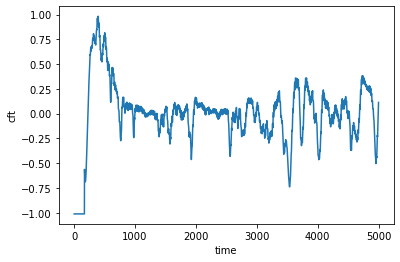

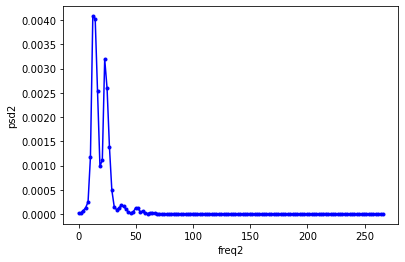

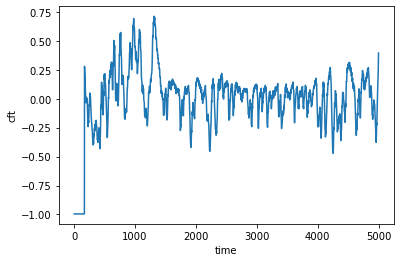

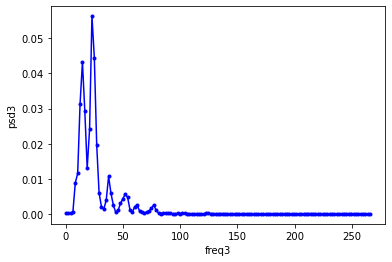

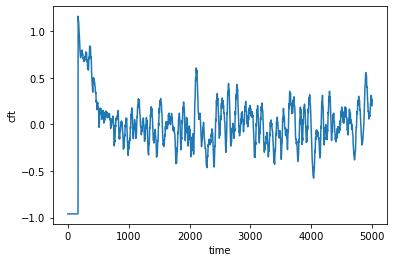

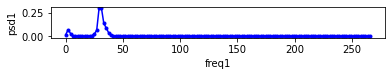

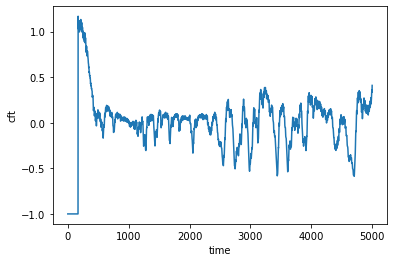

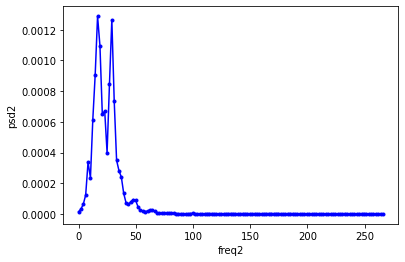

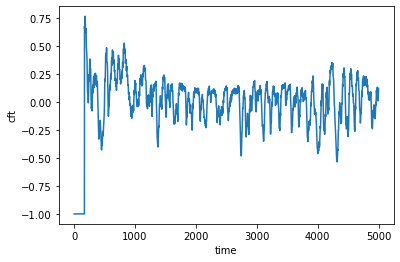

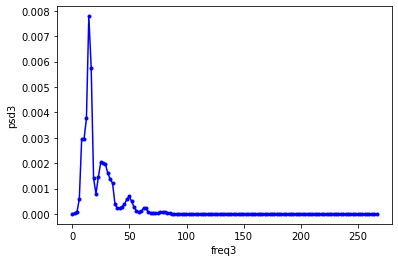

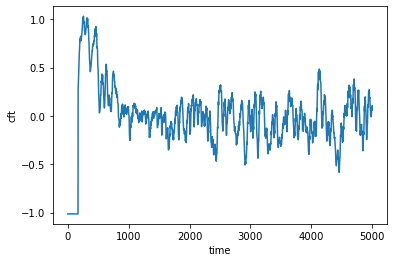

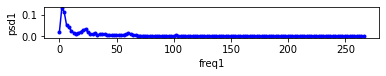

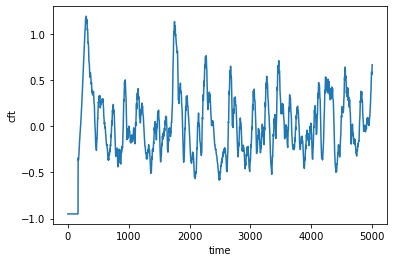

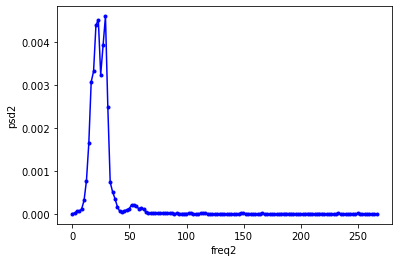

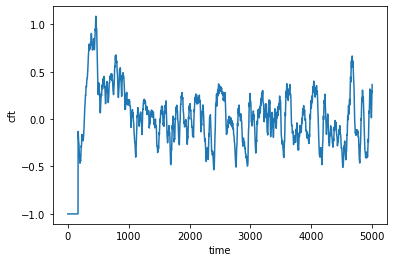

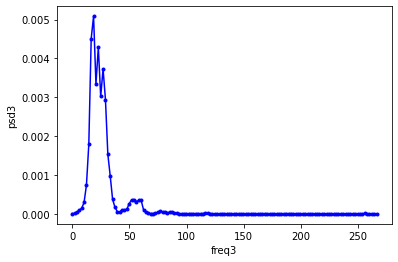

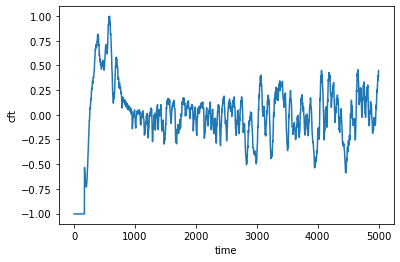

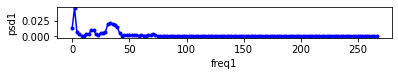

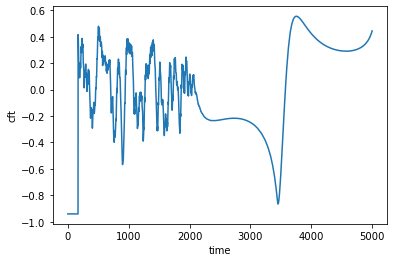

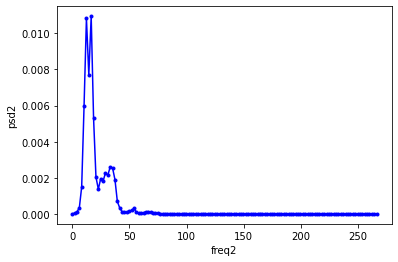

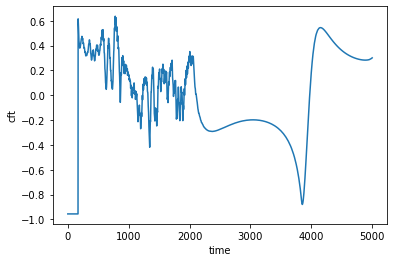

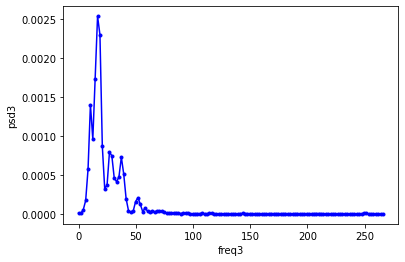

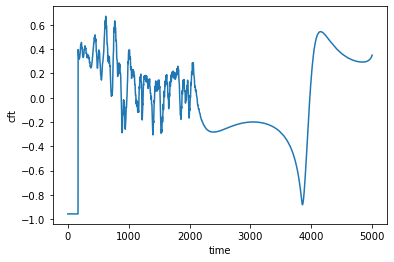

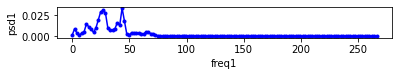

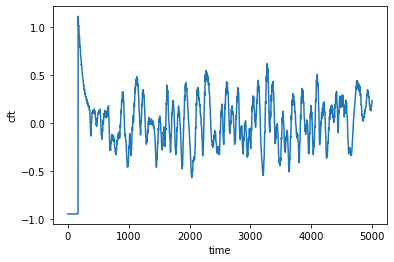

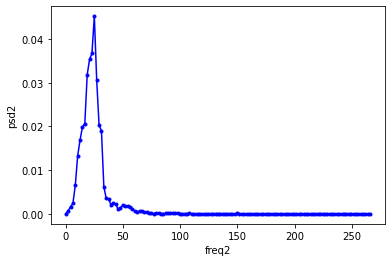

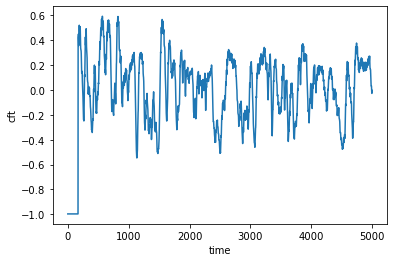

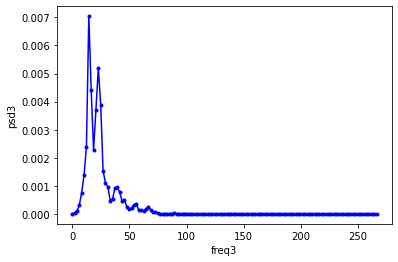

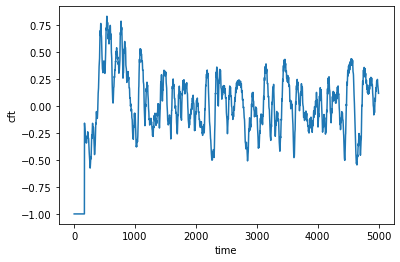

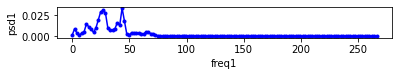

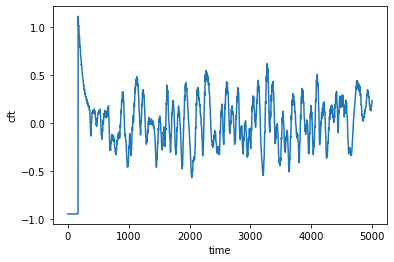

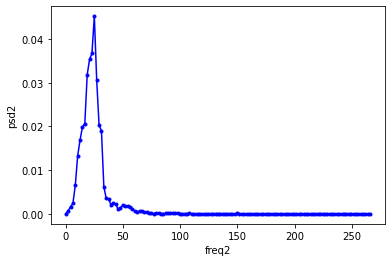

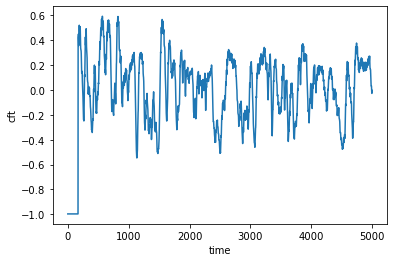

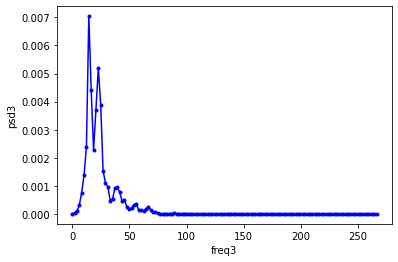

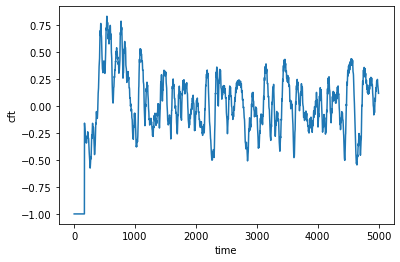

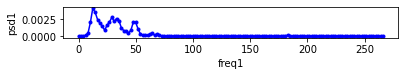

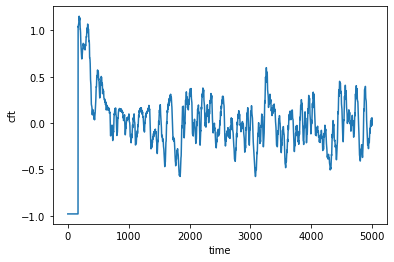

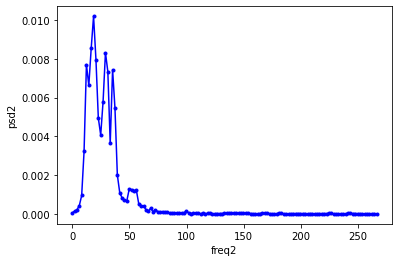

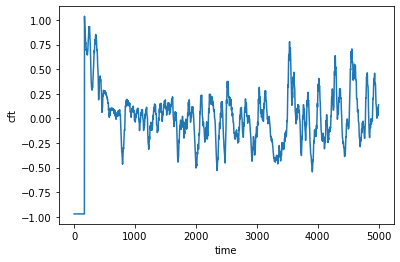

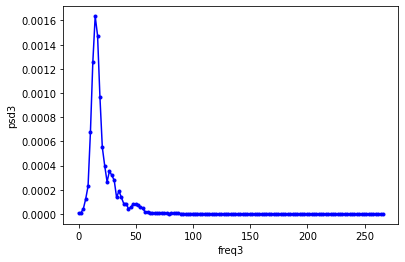

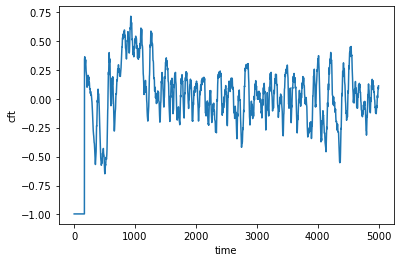

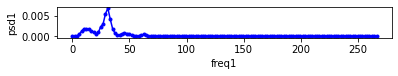

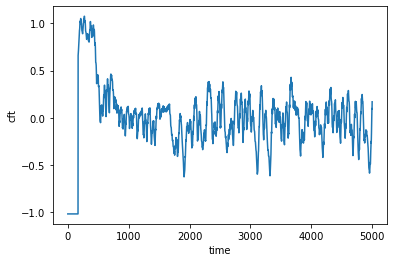

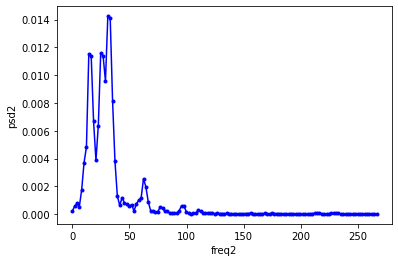

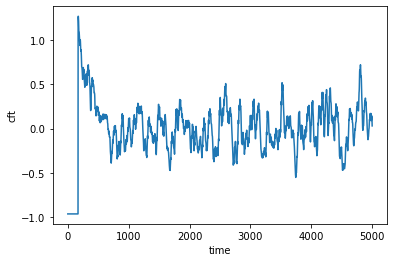

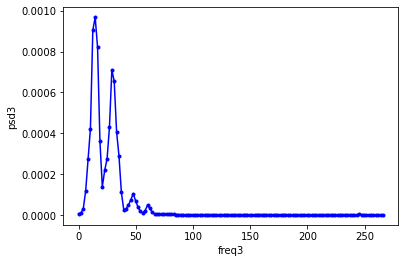

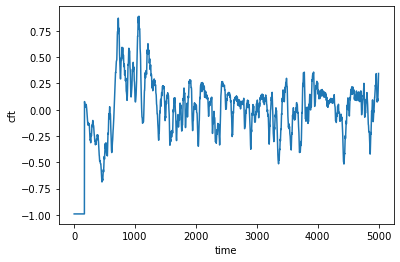

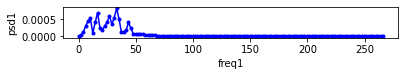

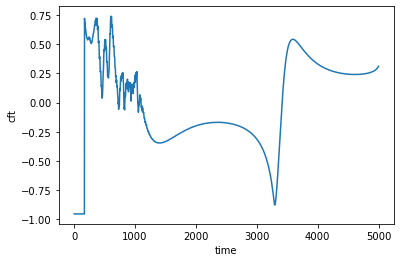

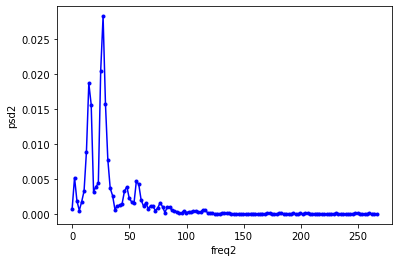

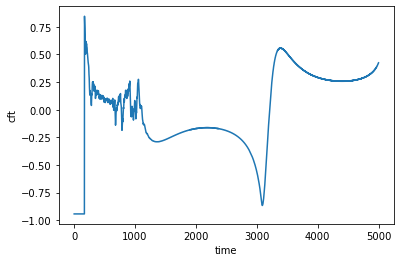

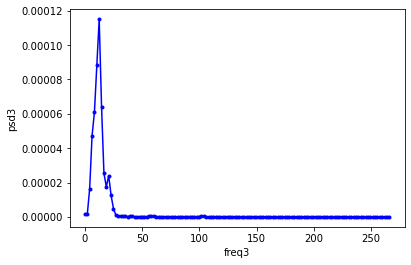

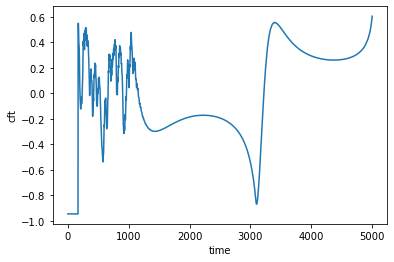

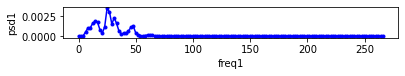

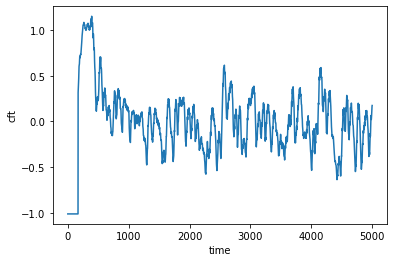

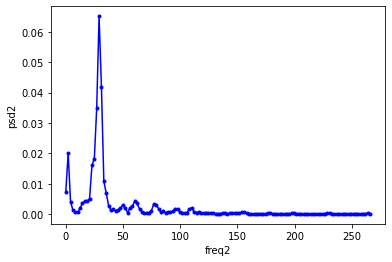

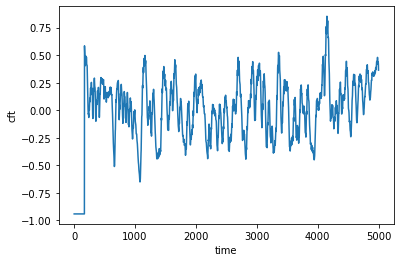

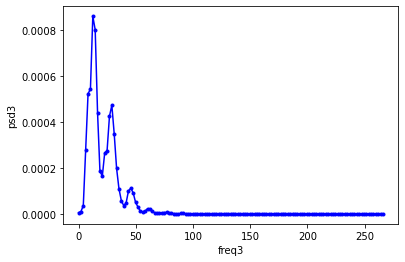

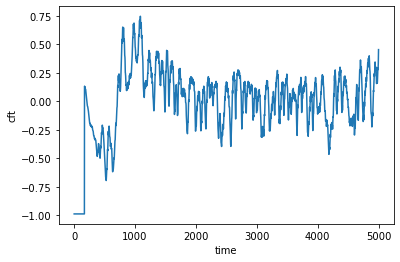

In [72]:
for i in range(1,14):
    file_name='thumper'+str(i)+'.csv'
    rec_x=np.array(pd.read_csv(file_name)['X'])
    rec_y=np.array(pd.read_csv(file_name)['Y'])
    rec_z=np.array(pd.read_csv(file_name)['Z'])
    time=np.linspace(0,4997.984856,2650)
    freq1,psd=signal.welch(rec_y,532)
    freq,psd1=signal.welch(rec_x,532)
    freq,psd2=signal.welch(rec_z,532)
    plt.figure()
    plt.subplot(6,1,1)
    plt.plot(freq,psd,'b.-')
    print(freq[np.where(psd==psd.max())])
    plt.xlabel('freq1')
    plt.ylabel('psd1')
    event,len_event,index_on,index_off=trigger_event(1,-0.5,rec_y,time,10,90,500)
    plt.figure()
    plt.plot(freq,psd1,'b.-')
    print(freq[np.where(psd1==psd1.max())])
    plt.xlabel('freq2')
    plt.ylabel('psd2')
    event1,len_event1,index_on1,index_off1=trigger_event(1,-0.5,rec_x,time,10,90,500)
    plt.figure()
    plt.plot(freq,psd2,'b.-')
    print(freq[np.where(psd2==psd2.max())])
    plt.xlabel('freq3')
    plt.ylabel('psd3')
    event2,len_event2,index_on2,index_off2=trigger_event(1,-0.5,rec_z,time,10,90,500)
    time_arrival=np.zeros((len_event))
    for j in range(len_event):
        time_arrival[j]=time[index_on[j]]
        energy1=energy(event,len_event,index_on,index_off)
    peak_freq[i][0]=freq[np.where(psd==psd.max())]
    peak_freq[i][1]=freq[np.where(psd1==psd1.max())]
    peak_freq[i][2]=freq[np.where(psd2==psd2.max())]

In [49]:
peak_freq
np.write_txt()

array([[  0.      ,   0.      ,   0.      ],
       [ 31.171875,  22.859375,   2.078125],
       [ 31.171875,  18.703125,  22.859375],
       [ 31.171875,  18.703125,  18.703125],
       [ 24.9375  ,  12.46875 ,  22.859375],
       [ 29.09375 ,  16.625   ,  14.546875],
       [  2.078125,  29.09375 ,  18.703125],
       [  2.078125,  16.625   ,  16.625   ],
       [ 43.640625,  24.9375  ,  14.546875],
       [ 43.640625,  24.9375  ,  14.546875],
       [ 12.46875 ,  18.703125,  14.546875],
       [ 31.171875,  31.171875,  14.546875],
       [ 33.25    ,  27.015625,  12.46875 ],
       [ 24.9375  ,  29.09375 ,  12.46875 ],
       [  0.      ,   0.      ,   0.      ]])

In [74]:
import csv
f = open('thumper_freq.csv', 'w')  # X is an array
writer = csv.writer(f)
for i in range(len(peak_freq)):
    writer.writerow(peak_freq[i])
f.close()  

In [64]:
import math

[ 8.203125]


ValueError: x and y must have same first dimension, but have shapes (6481,) and (2308,)

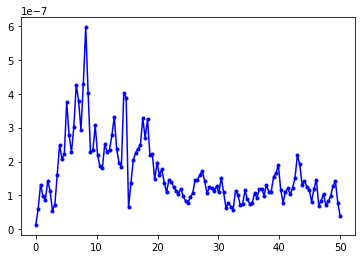

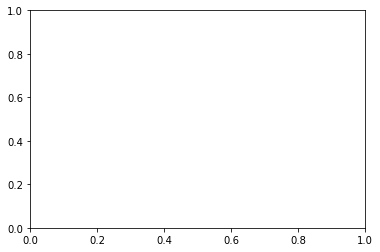

In [64]:
file_name='test_10.csv'

rec_x=np.array(pd.read_csv(file_name)['X'])
rec_y=np.array(pd.read_csv(file_name)['Y'])
rec_z=np.array(pd.read_csv(file_name)['Z'])
time=np.linspace(0,4997.984856,6481)
freq,psd=signal.welch(rec_y,100)
fig=plt.figure()
plt.plot(freq,psd,'b.-')
print(freq[np.where(psd==psd.max())])
event,len_event,index_on,index_off=trigger_event(1,-0.5,np.sqrt(rec_x**2+rec_y**2+rec_z**2),time,10,90,500)
time_arrival=np.zeros((len_event))
for j in range(len_event):
    time_arrival[j]=time[index_on[j]]
    energy1=energy(event,len_event,index_on,index_off)

In [55]:
rec_x

array([-0.038796, -0.058804, -0.052094, ...,       nan,       nan,
             nan])